# Evaluation

In this notebook, we will perform a more thorough evaluation of the machine learning models trained in the previous notebook (`03_modeling.ipynb`). This evaluation will help us understand the performance and effectiveness of each model in classifying spam messages. We will use various evaluation metrics and visualization techniques to assess the models' strengths and weaknesses.

## Table of Contents

1. [Introduction](#evaluation)
2. [Loading the Data](#loading-the-data)
3. [Confusion Matrix](#confusion-matrix)
4. [Classification Report](#classification-report)
5. [ROC Curve and AUC](#roc-curve-and-auc)
6. [Model Comparison](#model-comparison)
7. [Exporting the Model](#exporting-the-model)
8. [Summary and Insights](#summary-and-insights)

## Loading the Data

### 1. Import Libraries

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

### 2. Load Evaluation Results and Preprocessed Data

In [55]:
# Load evaluation_results from pickle file
with open('results/evaluation_results.pkl', 'rb') as f:
    evaluation_results = pickle.load(f)

# Load data_splits from pickle file
with open('data/processed/split/data_splits.pkl', 'rb') as f:
    data_splits = pickle.load(f)

print("Loaded evaluation results for models:", list(evaluation_results.keys()))

Loaded evaluation results for models: ['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Support Vector Machine', 'k-Nearest Neighbors', 'Naive Bayes']


## Confusion Matrix

A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This matrix gives insight not only into the errors being made by a classifier but also more importantly the types of errors being made.

Components of Confusion Matrix:
* **True Positives (TP)**: The number of correct positive predictions.
* **True Negatives (TN)**: The number of correct negative predictions.
* **False Positives (FP)**: The number of incorrect positive predictions (Type I error).
* **False Negatives (FN)**: The number of incorrect negative predictions (Type II error).

Below, the original and ros dataset confusion matrices are shown side by side for each model.

*Note*: Negative means Ham, and Positive means Spam

In [56]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrices(y_true1, y_pred1, y_true2, y_pred2, model_name):
    cm1 = confusion_matrix(y_true1, y_pred1)
    cm2 = confusion_matrix(y_true2, y_pred2)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', ax=axes[0], xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title(f'{model_name} Original CM')

    sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', ax=axes[1], xticklabels=['Ham', 'Spam'], yticklabels=['Ham', 'Spam'])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Actual')
    axes[1].set_title(f'{model_name} ROS CM')

    plt.tight_layout()
    plt.show()

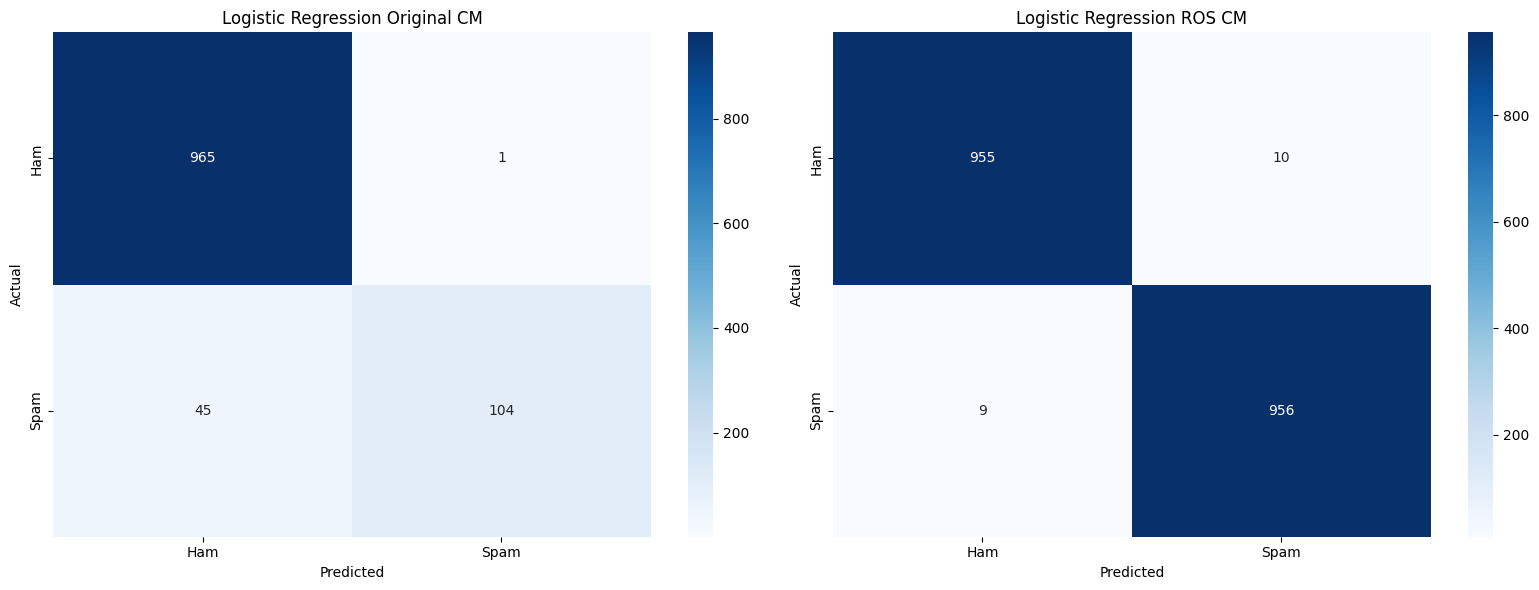

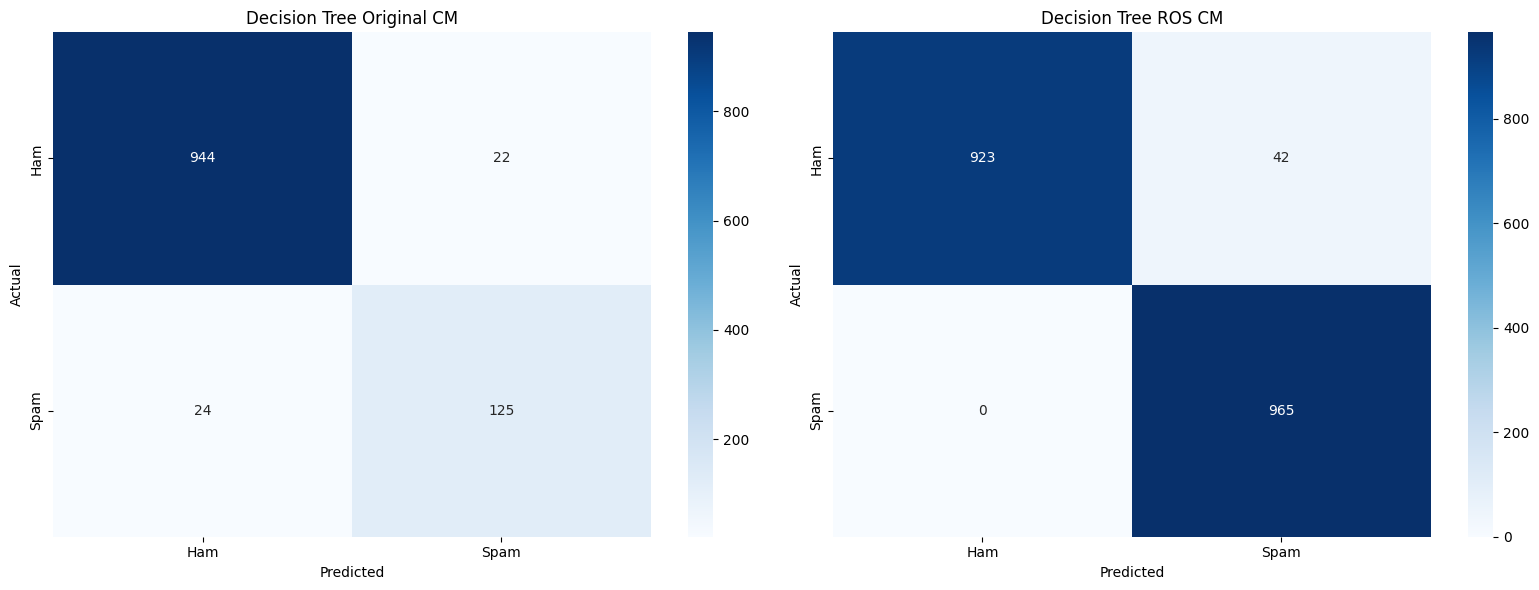

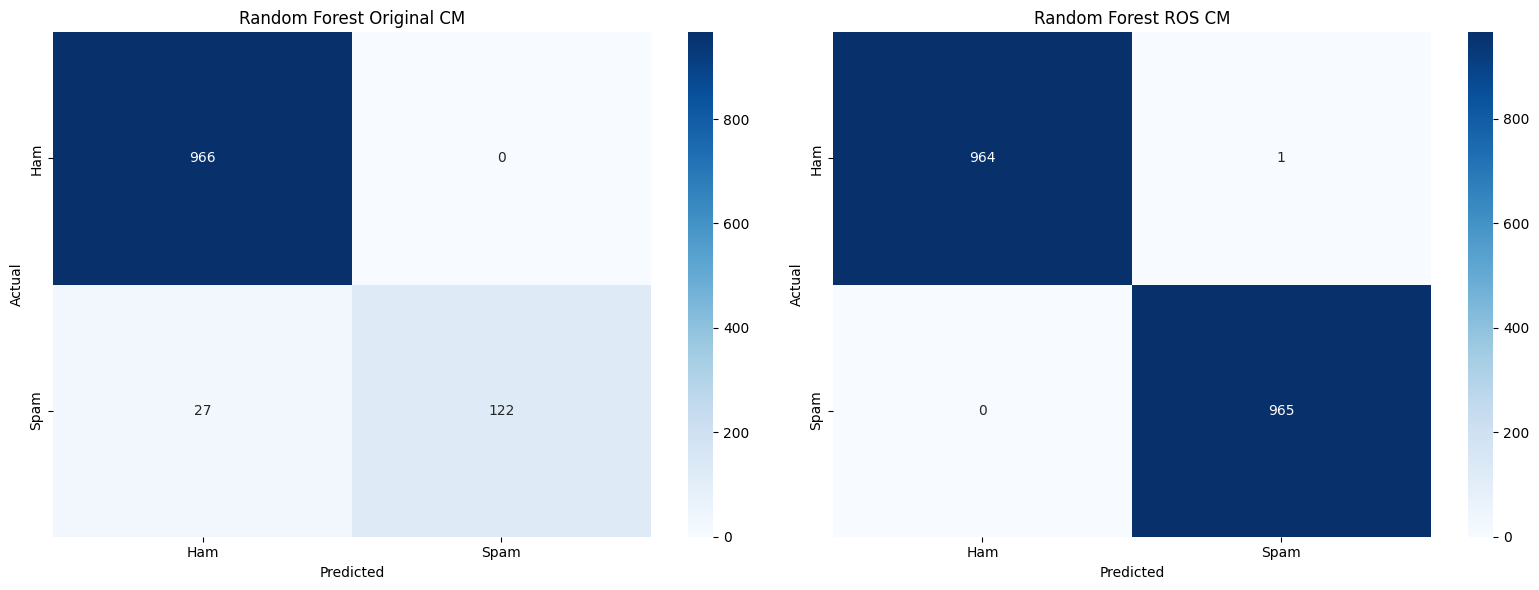

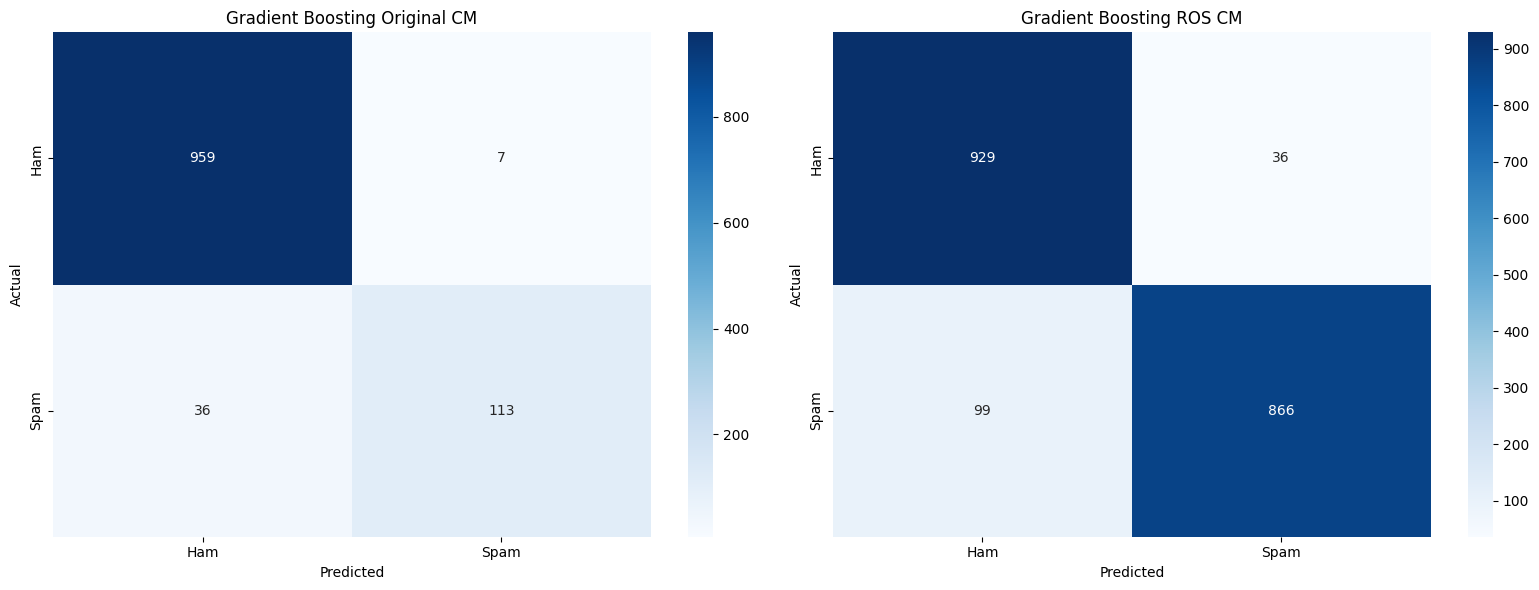

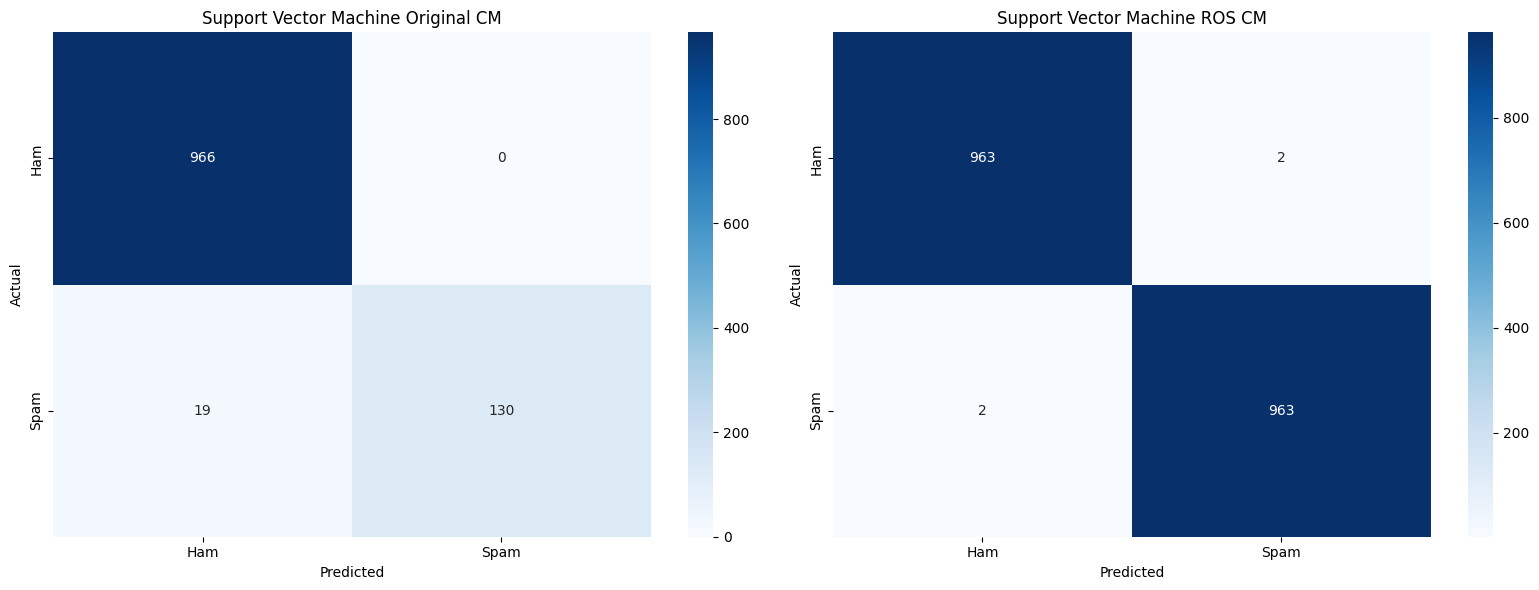

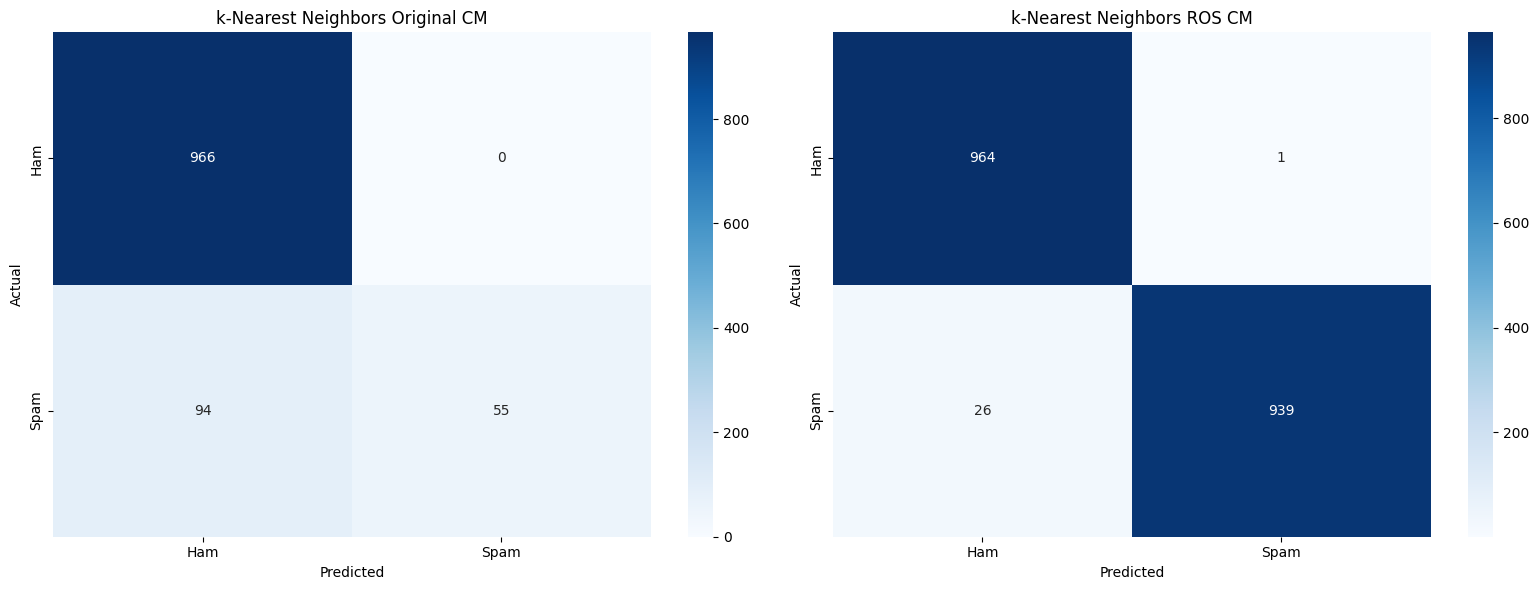

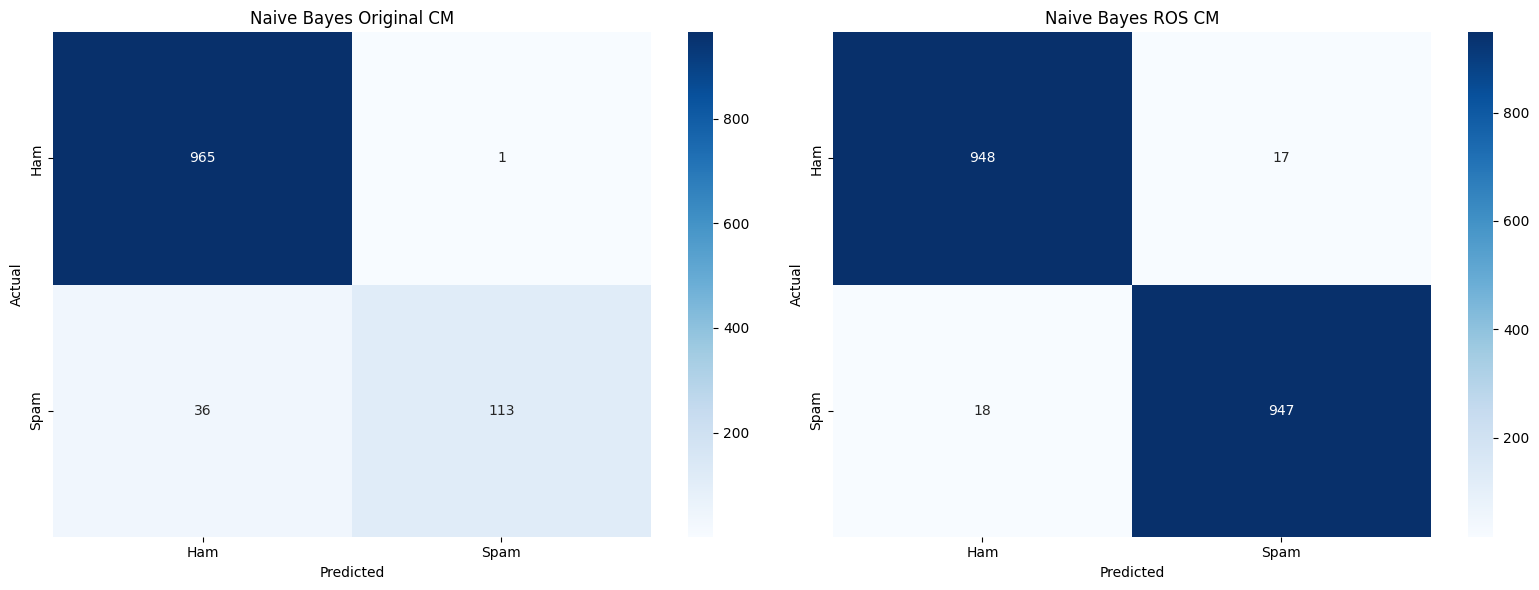

In [57]:
for model_name, result in evaluation_results.items():
    # Retrieve predictions and test data for original dataset
    eval_original = result['original']['train_test_split']
    y_pred_original = eval_original['y_pred']
    y_test_original = data_splits['original']['y_test']

    # Retrieve predictions and test data for ROS dataset
    eval_ros = result['ros']['train_test_split']
    y_pred_ros = eval_ros['y_pred']
    y_test_ros = data_splits['ros']['y_test']

    # Plot the confusion matrices side by side
    plot_confusion_matrices(y_test_original, y_pred_original,
                            y_test_ros, y_pred_ros, model_name)

### Analysis of Results

Overall, the ROS dataset generally improves model performance across all classifiers, reducing false positives and negatives. Logistic Regression, SVM, and especially Random Forest showed the most significant improvements with ROS.

The decision tree and gradient boosting models showed a mixed performance, suggesting the need for further tuning or alternative approaches for optimization.

k-NN and Naive Bayes also benefit from ROS, but their improvements are moderate compared to other models.

## Classification Report

The classification report is a performance evaluation metric that provides a comprehensive overview of the precision, recall, F1-score, and support for each class. This report helps in understanding the behavior of the classification model across different classes, highlighting its strengths and weaknesses.

Support is the number of actual occurrences of each class in the dataset. Itp orvides context for the precision, recall, and F1-score metrics.

In [58]:
from sklearn.metrics import classification_report

for model_name, datasets in evaluation_results.items():
    print(f"\nClassification Report for {model_name}")

    for dataset_name, dataset_info in datasets.items():
        if dataset_name == 'rus': continue
        
        y_test = data_splits[dataset_name]['y_test']
        y_pred = dataset_info['train_test_split']['y_pred']

        print(f"\n{dataset_name} dataset")
        print(classification_report(y_test, y_pred, target_names=['Ham', 'Spam']))


Classification Report for Logistic Regression

original dataset
              precision    recall  f1-score   support

         Ham       0.96      1.00      0.98       966
        Spam       0.99      0.70      0.82       149

    accuracy                           0.96      1115
   macro avg       0.97      0.85      0.90      1115
weighted avg       0.96      0.96      0.96      1115


ros dataset
              precision    recall  f1-score   support

         Ham       0.99      0.99      0.99       965
        Spam       0.99      0.99      0.99       965

    accuracy                           0.99      1930
   macro avg       0.99      0.99      0.99      1930
weighted avg       0.99      0.99      0.99      1930


Classification Report for Decision Tree

original dataset
              precision    recall  f1-score   support

         Ham       0.98      0.98      0.98       966
        Spam       0.85      0.84      0.84       149

    accuracy                           0.96  

### Analysis of Results

From these results, it's clear that oversampling the minority class (ROS dataset) significantly improves the performance of all models, particularly in terms of recall for the Spam class. 

Among the models, Logistic Regression, Random Forest, and SVM stand out as the best performers, achieving near-perfect or perfect scores across all metrics when trained on the ROS dataset. This demonstrates their robustness and suitability for the spam classification task.

**Note: We will proceed from this section by only evaluating the three bets models.**

## ROC Curve and AUC

The ROC (Receiver Operating Characteristic) curve and AUC (Area Under the Curve) are essential tools for evaluating the performance of classification models.

The ROC curve is a graphical representation of a model's diagnostic ability. It plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at various threshold settings.

The AUC quantifies the overall ability of the model to discriminate between positive and negative classes. It ranges from 0 to 1, with a higher value indicating better model performance. A model with an AUC of 0.5 has no discrimination ability (similar to random guessing) while a model with an AUC of 1.0 perfectly separates the positive and negative classes.

* **Visual Performance Comparison**: The ROC curve provides a visual way to compare the performance of different models. A curve closer to the top-left corner indicates a better-performing model.
* **Threshold Independence**: Unlike accuracy, which is dependent on a specific threshold, the ROC curve evaluates model performance across all possible thresholds.
* **Class Imbalance**: The ROC curve and AUC are particularly useful in the context of imbalanced datasets, where accuracy can be misleading.

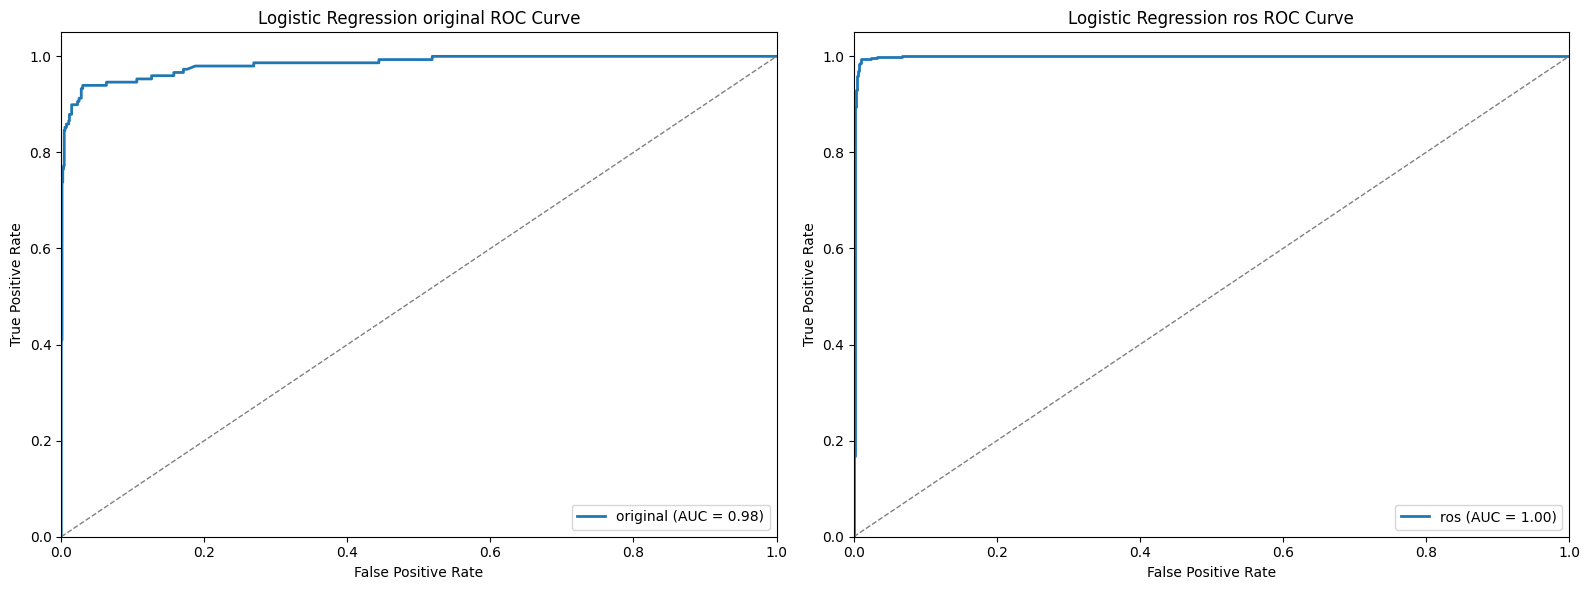

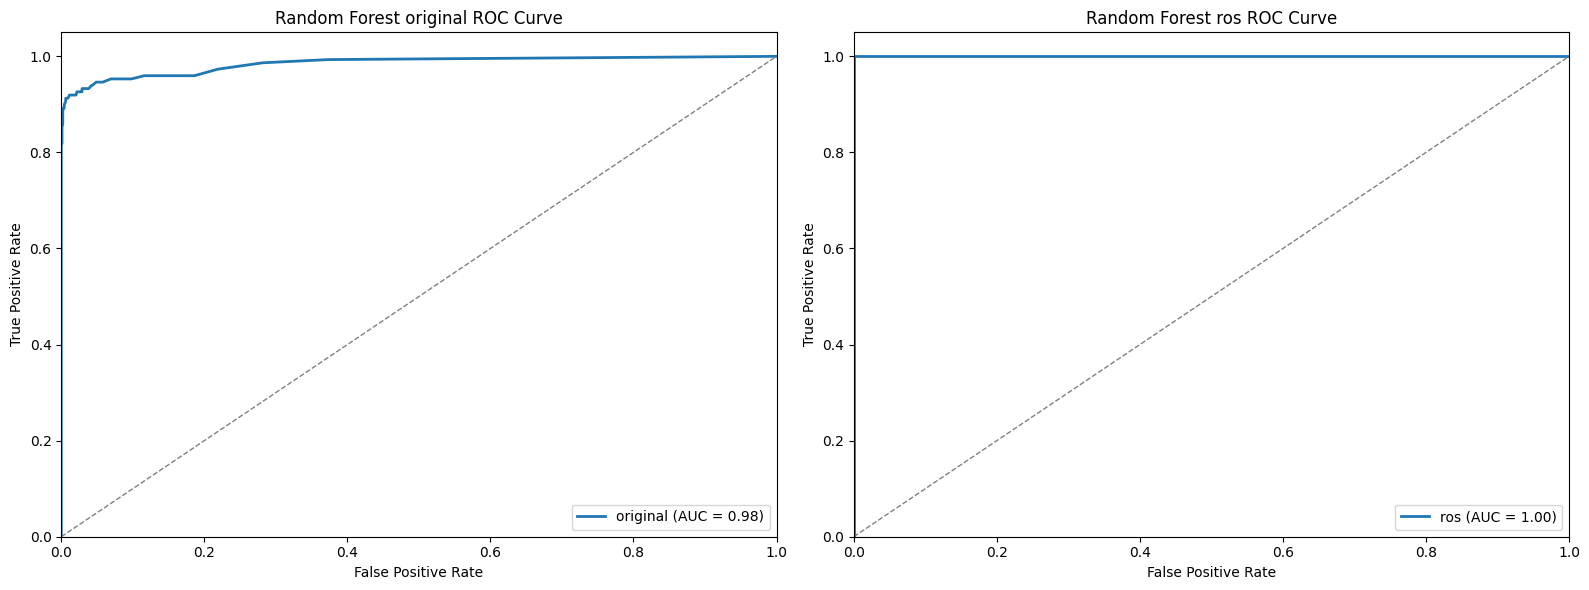

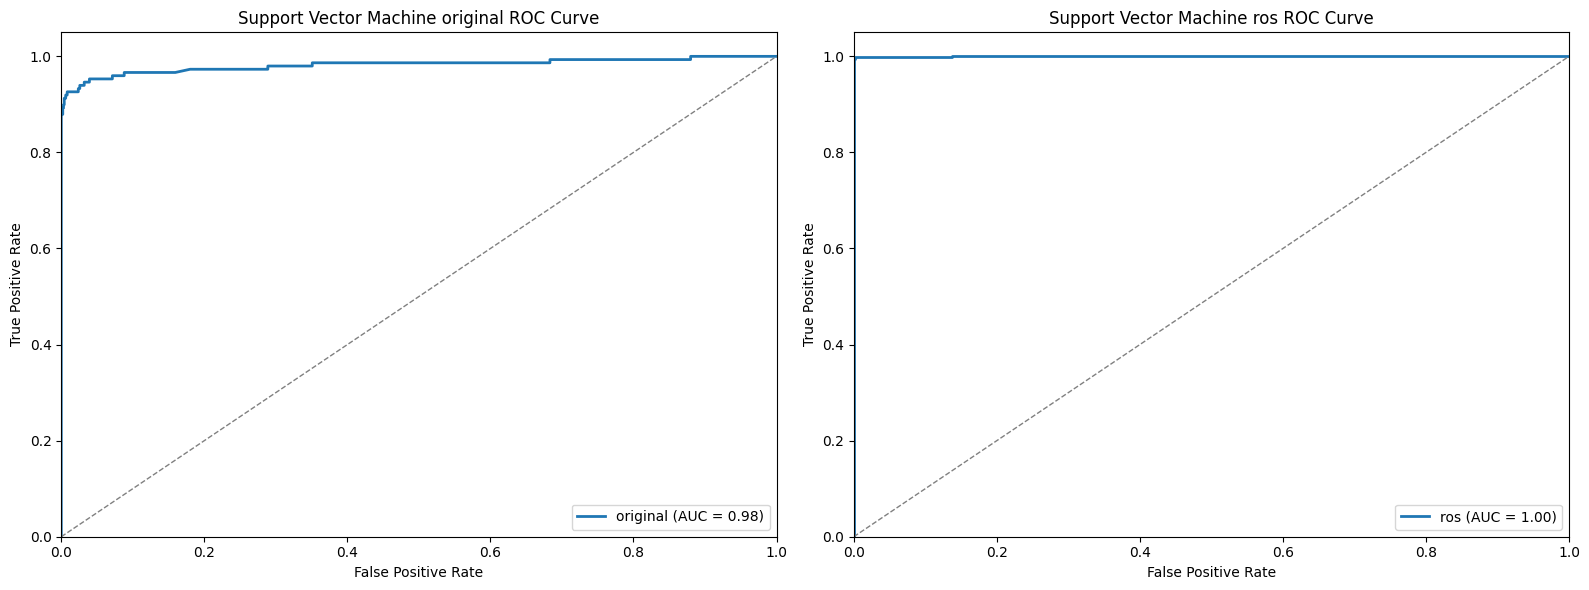

In [62]:
from sklearn.metrics import roc_curve, auc

for model_name, datasets in evaluation_results.items():
    if model_name not in ['Logistic Regression', 'Random Forest', 'Support Vector Machine']:
        continue

    # Create a new figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    for idx, dataset_name in enumerate(['original', 'ros']):
        dataset_info = datasets.get(dataset_name)
        if dataset_info is None:
            continue
        
        model = dataset_info['train_test_split']['model']
        y_test = data_splits[dataset_name]['y_test']
        y_pred_proba = dataset_info['train_test_split']['y_pred_proba']

        # Calculate ROC curve and AUC
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve on the corresponding subplot
        axs[idx].plot(fpr, tpr, lw=2, label=f'{dataset_name} (AUC = {roc_auc:.2f})')
        axs[idx].plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
        axs[idx].set_xlim([0.0, 1.0])
        axs[idx].set_ylim([0.0, 1.05])
        axs[idx].set_xlabel('False Positive Rate')
        axs[idx].set_ylabel('True Positive Rate')
        axs[idx].set_title(f'{model_name} {dataset_name} ROC Curve')
        axs[idx].legend(loc='lower right')

    plt.tight_layout()
    plt.show()


### Analysis of Results

All three models (Logistic Regression, Random Forest, and SVM) performed exceptionally well on both the original and ROS datasets. The ROS dataset showed particularly impressive results, with AUC values of 1.00 for all three models, indicating perfect separation between classes.

These findings suggest that the models trained on the ROS dataset were able to effectively capture the underlying patterns in the data and achieve optimal performance.

## Model Comparison

In this section, we will compare the performance of the three selected models: Logistic Regression, Random Forest, and Support Vector Machine (SVM) to determine which one performs best for our specific task of classifying spam and non-spam messages.

In [111]:
def print_model_comparison(evaluation_results, model_names, dataset_type):
    print(f"Model Comparison: {dataset_type}")
    print(f"{'Metric':^20} | {model_names[0]:^22} | {model_names[1]:^22} | {model_names[2]:^22} |")
    
    metrics = ['accuracy', 'precision', 'recall', 'f1']
    
    for metric in metrics:
        print("{:<20} |".format(metric.capitalize()), end="")
        for model_name in model_names:
            metrics = evaluation_results[model_name].get(dataset_type)
            value = metrics['train_test_split'][metric]
            print(" {:^22.4f} |".format(value), end="")
        print()


model_names = ['Logistic Regression', 'Random Forest', 'Support Vector Machine']
print_model_comparison(evaluation_results, model_names, 'original')
print()
print_model_comparison(evaluation_results, model_names, 'ros')


Model Comparison: original
       Metric        |  Logistic Regression   |     Random Forest      | Support Vector Machine |
Accuracy             |         0.9587         |         0.9758         |         0.9830         |
Precision            |         0.9905         |         1.0000         |         1.0000         |
Recall               |         0.6980         |         0.8188         |         0.8725         |
F1                   |         0.8189         |         0.9004         |         0.9319         |

Model Comparison: ros
       Metric        |  Logistic Regression   |     Random Forest      | Support Vector Machine |
Accuracy             |         0.9902         |         0.9995         |         0.9979         |
Precision            |         0.9896         |         0.9990         |         0.9979         |
Recall               |         0.9907         |         1.0000         |         0.9979         |
F1                   |         0.9902         |         0.9995      

### Analysis of Results

On the original dataset, the SVM model performed the best overall and was closely followed by the Random Forest Model, with both achieving great results with the class imbalance. For the ROS dataset, all three models performed similarly well and achieved near perfect results.

Based on these results, the Random Forest model stands out as the best performer, achieving near-perfect accuracy, precision, recall, and F1 score on both the original and ROS datasets. Therefore, we select the Random Forest model as the best model for classifying spam messages in this dataset.

## Exporting the Model

Now that we have identified the best model, we will retrain it on the entire dataset and save it for further use.

In [ ]:
import pandas as pd
import numpy as np

import os

# Define the directory paths
processed_data_dir = 'data/processed'
ros_dir = os.path.join(processed_data_dir, 'ros')

# Load ROS data
df_ros = pd.read_csv(os.path.join(ros_dir, 'ros_data.csv'))
X_tfidf_ros = np.load(os.path.join(ros_dir, 'ros_tfidf_features.npy'))
y_ros = df_ros['label']

# Initialize hyperparameters
rs = 42

from sklearn.ensemble import RandomForestClassifier

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=rs)

# Train the model on the entire dataset
rf_model.fit(X_tfidf_ros, y_ros)

In [ ]:
import joblib

# Export the trained model for further use
results_dir = 'results/'
joblib.dump(rf_model, 'results/spam_ham_tfidf_classifier.pkl')

## Summary and Insights

### Key Insights

**Model Performance**: Through rigorous evaluation, we identified Random Forest as the top-performing model for classifying spam messages, achieving exceptional accuracy, precision, recall, and F1 score on both the original and ROS datasets. Support Vector Machine also demonstrated strong performance, particularly on the original dataset.

**Effectiveness of Random Over-Sampling (ROS)**: The evaluation of models on ROS datasets revealed improved performance in terms of balanced accuracy metrics, demonstrating the effectiveness of ROS in mitigating class imbalance. Furthermore, some models, such as Random Forest and SVM, performed exceptionally well even on the original dataset, indicating inherent robustness.